<a href="https://colab.research.google.com/github/sayan0506/Synthetic-Image-generation-using-VAE-/blob/main/Implement_VAE_using_Keras_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

Importing nercessary modules, here we will implement the VAE using the tensorflow backend from scratch

In [70]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from keras.datasets import mnist
# this keras backend will help to do some basic calculations or math stuffs
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

# Load MNIST

Loading the traina and test dataset of digits

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
print(f'Shape of the dataset: {x_train.shape}, {y_train.shape}, {x_test.shape}, {y_test.shape}')

Shape of the dataset: (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)


# Data Pre-processing

## Normalizing the dataset

In [45]:
# as VAE is a autoencoder based network, no need of classification information
# so we will only deal with the images
# converting the pixels to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalizing the dataset
x_train = x_train / 255.
x_test = x_test / 255.

## Reshaping the dataset

In [46]:
# reshape the data
num_channels = 1
# reshaping the images to 4 dimensional space shape = (m, width, height, channels)
# skipped 1st 3 dimensions and adding new axis where we add channel axis
# for grayscale image channel = 1
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

# shape after reshaping
print(f'Reshaped size: {x_train.shape}, {x_test.shape}')

Reshaped size: (60000, 28, 28, 1), (10000, 28, 28, 1)


# Data Visualization

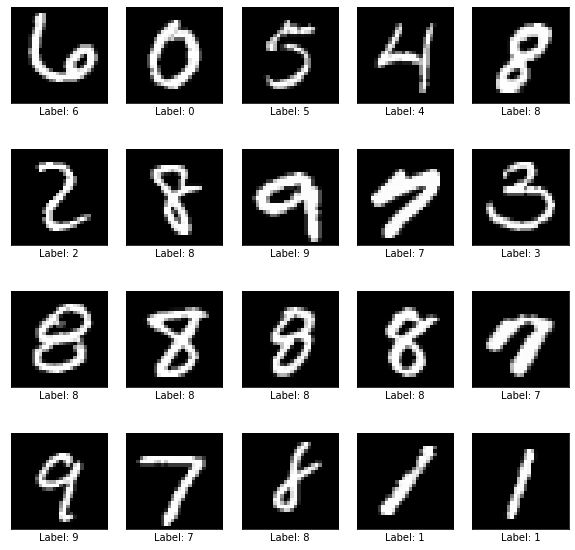

In [54]:
# let ius visualzie 20 random sample training images

# rows = 4
r = 4
# columns = 5
c = 5

fig = plt.figure(figsize=(10,10))

for i in range(r * c):
  fig.add_subplot(r, c, i + 1)
  # random image no
  img_id = np.random.randint(0, x_train.shape[0])
  # np.squeeze the all unimportant dimensions, here m = 1, c = 1 for single image
  plt.imshow(np.squeeze(x_train[img_id]), cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'Label: {y_train[img_id]}')
  # plt.axis('off')

fig.show()

## Defining the parameters

In [56]:
# definingthe input image shape
img_width = x_train.shape[1]
img_height = x_train.shape[2]
input_img_shape = (img_width, img_height, num_channels)
 
# latent space dimension considered to be 2D here
latent_dim = 2

# Building the Computational Graph of the Variational Autoencoder

* The variational autoencoder consists of encoder + latent_space + decoder
* The latent space consists of the combination of mean(mu) + std(sigma) layer
* We will use keras **Functional API** for the network

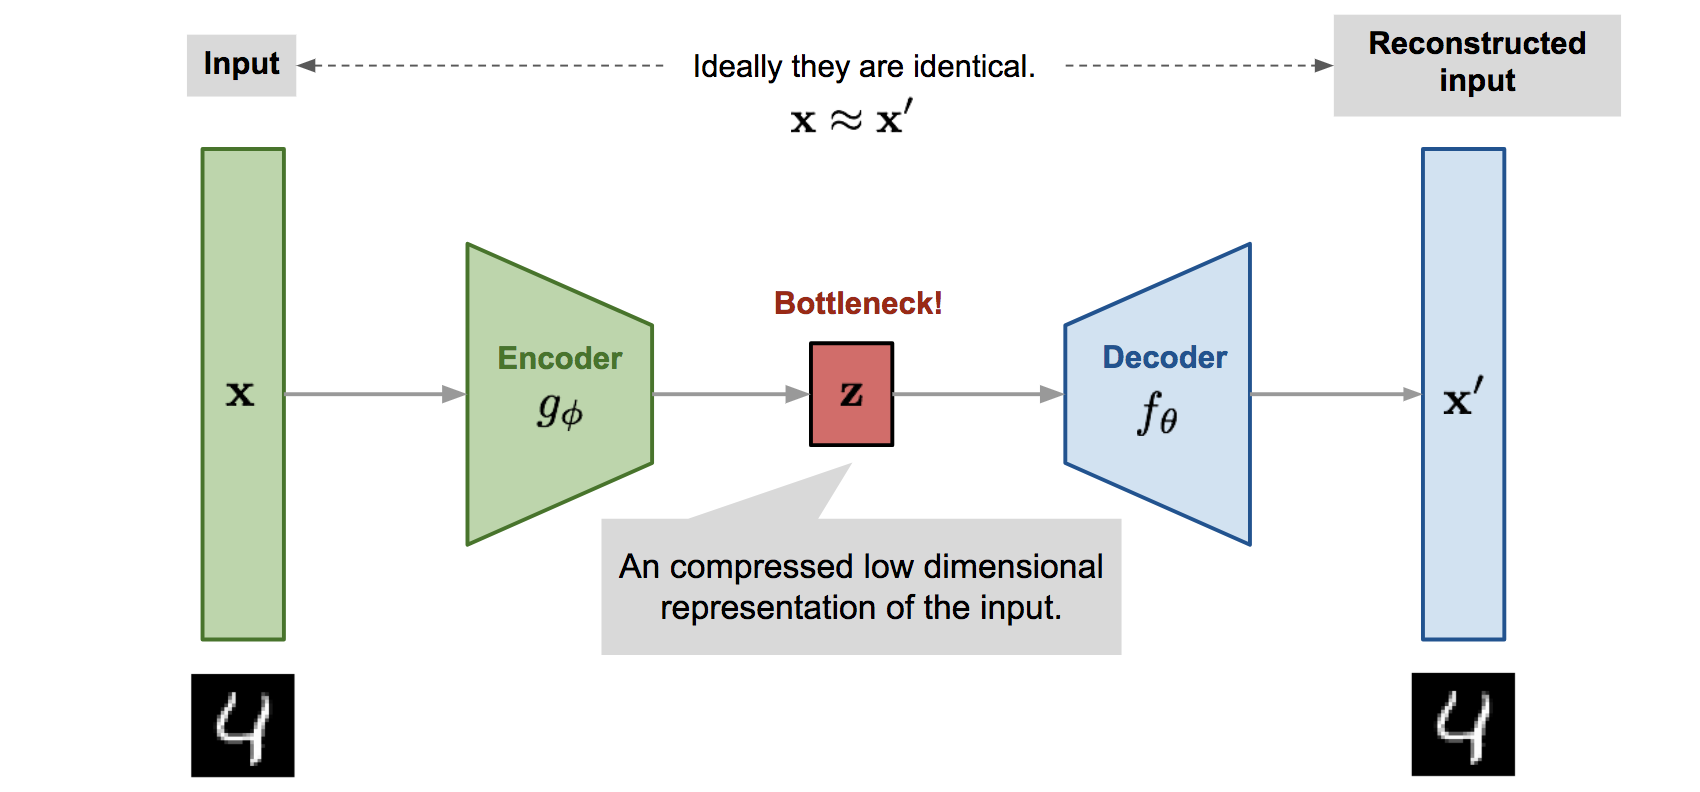

[image_link](https://www.google.com/url?sa=i&url=https%3A%2F%2Flilianweng.github.io%2Flil-log%2F2018%2F08%2F12%2Ffrom-autoencoder-to-beta-vae.html&psig=AOvVaw3-6qbk7x5xUZtop7SEl2sO&ust=1610287747220000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKjrmZ-Dj-4CFQAAAAAdAAAAABAJ)

## Encoder section

* The encoder consists of 4 conv2d
* Then, the output is fed to a Flatten layer, then to a dense layer

In [63]:
# encoder convolution section
input_img = Input(shape = input_img_shape, name = 'VAE_encoder_input')
x = Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu')(input_img)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
                                                                                                                                                                                                                                                                                         
# As decoder reconstructs the image, so 1st convolution of decoder willbe transpose and having same shape as the 4th Conv2D
# shape of cnv2 to be provided to the decoder
conv_shape = K.int_shape(x)

# Flatten 
x = Flatten()(x)
# dense layer
x = Dense(32, activation = 'relu')(x)

## **Reparameterization Trick**

We need to do reparameterization for executing gradients inside the expectation variable correspond to the reconstruction loss of the variational lower bound, where we do a trasnformation for the latent space samples

> **z = mean_encoder_section + epsilon * sqrt(covariance matrix correspond to encoder section)**

Here epsilon is the matrix which contains the random sample from the normal distribution **N~(0,1)** [That is the distribution we choose so that latent space can maintain it, which i regularized by the KL divergence term)

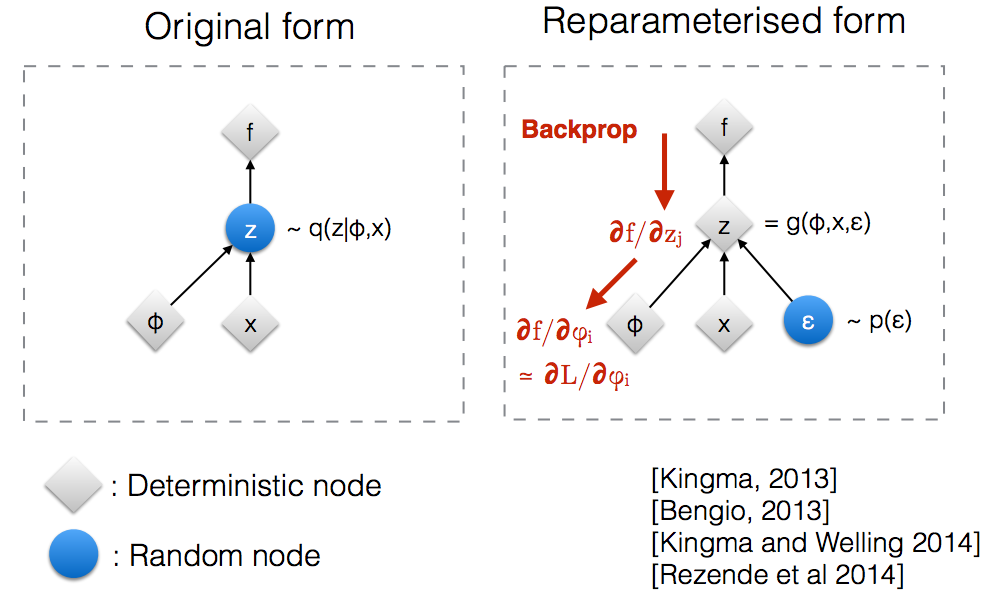

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 64)   36928       conv2d_18[0][0]                  
____________________________________________________________________________________________

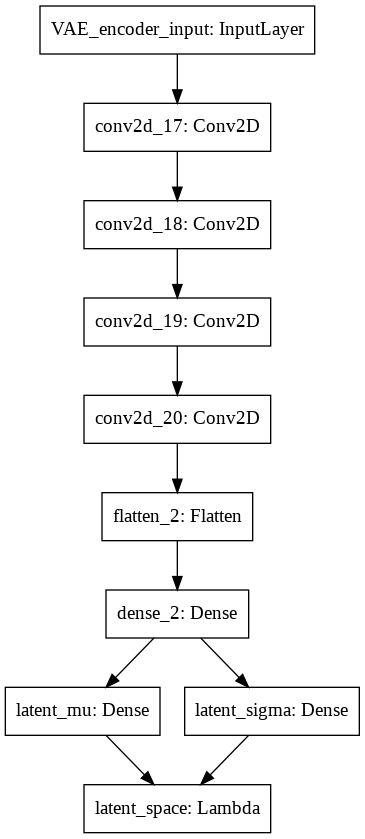

In [71]:
# mean layer
mean_layer = Dense(latent_dim, name = "latent_mu")(x)

# standard deviation hidden layer
std_layer = Dense(latent_dim, name = "latent_sigma")(x)

# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma * eps
# this is to allow gradient descent to estimate the gradients properly, or this helps to to make the z node from random to deterministic
# because we can't apply gradients on the stochastic node
def sample_z(args):
  z_mu, z_sigma = args
  # random samples from a normal distribution or a distribution we choose that the latent space should maintain
  epsilon = K.random_normal(shape = (K.shape(z_mu)[0], K.int_shape(z_mu)[1]), mean = 0.0, stddev = 1.0)
  # reparameterized z
  latent_z = z_mu + K.exp(1/2 * z_sigma) * epsilon

# now in lambda latent layer we need to add the gradient descent calculation
# using mu and variance(sigma)
# in Lambda layer we pass the function_name
z = Lambda(sample_z, output_shape = (latent_dim, ), name = 'latent_space')([mean_layer, std_layer])

# Define and summarize the Encoder Model
encoder = Model(input_img, [mean_layer, std_layer, z], name = 'encoder')
# Model summary
encoder.summary()
# plotting the model
plot_model(encoder)